Here we are doing further exploration of the email dataset by analyze the social network formed from those emails as all emails are from Enron employer and employees. Without analyze the actual content of each email using NLP, by forming the social network and analyze the centrality we can calculate the probability of each sender who is in the same close social circle with the receipient and therefore better predict the sender of an email based on the receipient information

In [ ]:
# all possible libraries I might need
import numpy as np
import pandas as pd
import re
import random
import email
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics 
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import TruncatedSVD

from scipy.sparse import coo_matrix, hstack

In [ ]:
enron_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/emails.csv", header=0, quoting=2)

In [ ]:
enron_data.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


**Data cleanning reference**

CHRISTIAN - Extracting-Emails-From-Enron-Data-Set
https://www.kaggle.com/code/cguzman09/extracting-emails-from-enron-data-set

KRIZSÓ GERGELY - The Enron scandal Network X dashboard
https://www.kaggle.com/code/lucifer19/the-enron-scandal-network-x-dashboard

In [ ]:
# we draw a random small size portion sample for better visualization of our idea 
emails = enron_data.sample(n = 1000, random_state = 0)

In [ ]:
#Functions for extracting feature data from the email.csv

#create a function to split text data by blank space
def split_text(text, match):	
    text = re.sub(r"\n\t", "", text)
    return re.split(match, text)

#create a function to extract proper text from the email body
def extract_body(text, substr):	
    result = re.split(substr, text)[-1]
    result = re.sub(r"([\n-])", "", result)
    return result

# below are functions for extrracting each filed of the data 

#- function to extract email addresses
def extract_emails(text, substr):
    result = re.findall("[^\s]+@[\w]+.[\w]+", str(text))
    if substr not in text:
        result = ""
    return result

#- function to extract subject
def extract_subject(text):

    list_of_words = re.split("\s", text)
    #using blanks to extract replies and forwards
    words_to_drop = ["Subject:","re:","Re:","RE:","fw:","Fw:", "FW:"]

    desired_words = []
    for word in list_of_words:
        if word not in words_to_drop:
            desired_words.append(word)

    r = re.compile("[\w]{3,}")
    processed_list = list(filter(r.match, desired_words))

    return processed_list 


In [ ]:
# we first slice the data into sections of file, message id, sender etc
emails["message_processed"] = emails.message.apply(lambda x : split_text(x, "\n"))

# take a look of the processed msg output, first 6 entries
print(emails.message_processed.head(6))

510816    [Message-ID: <20978984.1075839990072.JavaMail....
346872    [Message-ID: <8987828.1075842774735.JavaMail.e...
158351    [Message-ID: <30686869.1075860369073.JavaMail....
351661    [Message-ID: <4155293.1075842841039.JavaMail.e...
20325     [Message-ID: <12670521.1075862605089.JavaMail....
430414    [Message-ID: <18558225.1075851772759.JavaMail....
Name: message_processed, dtype: object


Next we will do feature extraction to extract useful information that can be used for the analysis such as "sender email", "recipient email". These info are critical for us to establish the relationship for the social network

In [ ]:
# Follow the format of the raw data (cols) and extract date, sender, receiver, subject and other receipient as bcc and cc
emails["date"] = emails.message_processed.apply(lambda x : x[1])
emails["sender_email"] = emails.message_processed.apply(lambda x : x[2])
emails["recipient_email"] = emails.message_processed.apply(lambda x : x[3])
emails["subject"] = emails.message_processed.apply(lambda x : x[4])
emails["cc"] = emails.message_processed.apply(lambda x : x[5])
emails["bcc"] = emails.message_processed.apply(lambda x : x[9])
#since for this social network we will not be anaylize the main content of the email we will ignore the body message of the emails

In [ ]:
# now we construct new data scheme

emails.loc[:,"date"] = emails.loc[:,"date"].apply(lambda x : x[10:22])

# extract sender and recipient email
emails.loc[:,"sender_email"] = emails.loc[:,"sender_email"].apply(lambda x : extract_emails(x, "From: "))
emails.loc[:,"recipient_email"] = emails.loc[:,"recipient_email"].apply(lambda x : extract_emails(x, "To: "))
emails.loc[:,"cc"] = emails.loc[:,"cc"].apply(lambda x : extract_emails(x, "Cc: "))
emails.loc[:,"bcc"] = emails.loc[:,"bcc"].apply(lambda x : extract_emails(x, "Bcc: "))
# we combine all the bcc and cc into the recipient list 
emails["all_recipient_emails"] = emails.apply(lambda x : list(x["recipient_email"]) + list(x["cc"]) + list(x["bcc"]), axis = 1)
# count the number of receipient 
emails["num_recipient"] = emails.recipient_email.apply(lambda x : len(x)) + emails.cc.apply(lambda x : len(x)) + emails.bcc.apply(lambda x : len(x))
# extract subject
emails.loc[:,"subject"] = emails.loc[:,"subject"].apply(lambda x : extract_subject(x))

#emails_df.loc[:,"recipient_1"] = emails_df.apply(lambda x : x["recipient_email"][0])
#=== select and reorder the colums
df = emails.loc[:,["date","sender_email","recipient_email", "all_recipient_emails","num_recipient", "subject"]]  

#df1 = emails_df.loc[:,["date","sender_email","recipient_1", "subject"]]
print(df.head())
#print(df1.head())


                date                 sender_email  \
510816   13 Dec 2001       [pete.davis@enron.com]   
346872   20 Mar 2001  [tyrell.harrison@enron.com]   
158351   15 Mar 2001     [rcarroll@bracepatt.com]   
351661   3 Jan 2001      [dwight.beach@enron.com]   
20325    26 Sep 2001        [l..denton@enron.com]   

                                          recipient_email  \
510816                             [pete.davis@enron.com]   
346872                           [gerald.nemec@enron.com]   
158351  [cyoder@enron.com, jsteffe@enron.com, rsanders...   
351661                           [gerald.nemec@enron.com]   
20325   [kysa.alport@enron.com, w..white@enron.com, wa...   

                                     all_recipient_emails  num_recipient  \
510816  [pete.davis@enron.com, albert.meyers@enron.com...             19   
346872  [gerald.nemec@enron.com, barry.tycholiz@enron....              3   
158351  [cyoder@enron.com, jsteffe@enron.com, rsanders...             12   
351661    

As we can see after we reorganized the dataset with this new order, we have senders for each email and receipts accordingly. Now it will be ideal to split recipient email addressed into colums like recipient 1, recipient 2, recipient 3 etc.

In [ ]:
from itertools import chain
# for this function, it simply seperate a list of receipient for an email
def seperate(df_col1, df_col2):
    result = pd.DataFrame({ "sender" : np.repeat(df_col1.values, df_col2.str.len()),"receiver": list(chain.from_iterable(df_col2))})
    result.sender = result.sender.apply(lambda x : x[0])
    return result

In [ ]:
# for this function, we only keep the first recipient along with the subject for future network plot edge attribute
def new_sepe(df_col1, df_col2, df_col3):
    n_result = pd.DataFrame({ "sender" : np.repeat(df_col1.values, df_col2.str.len()),"receiver": list(chain.from_iterable(df_col2)), "subj": np.repeat(df_col3.values, df_col2.str.len())})
    n_result.sender = n_result.sender.apply(lambda x : x[0])
    n_result.receiver = n_result.receiver.apply(lambda x : x)
    return n_result

In [ ]:
#these 2 dataframes are for different network plots
after_split = seperate(df.sender_email, df.all_recipient_emails)

In [ ]:
split_2 = new_sepe(df.sender_email, df.recipient_email, df.subject)

In [ ]:
print(split_2)
print(len(split_2))

                         sender                   receiver  \
0          pete.davis@enron.com       pete.davis@enron.com   
1     tyrell.harrison@enron.com     gerald.nemec@enron.com   
2        rcarroll@bracepatt.com           cyoder@enron.com   
3        rcarroll@bracepatt.com          jsteffe@enron.com   
4        rcarroll@bracepatt.com         rsanders@enron.com   
...                         ...                        ...   
7139  rudwell.johnson@enron.com     susan.bailey@enron.com   
7140  rudwell.johnson@enron.com  stephanie.panus@enron.com   
7141  rudwell.johnson@enron.com    samantha.boyd@enron.com   
7142  rudwell.johnson@enron.com       tana.jones@enron.com   
7143           saveus2@wrc.avis         <.taylor@enron.com   

                                                subj  
0                   [Start, Date:, HourAhead, hour:]  
1                     [Executed, letter, agreements]  
2     [Interventions, Tuscon, Complaint, Proceeding]  
3     [Interventions, Tuscon, Compl

In [ ]:
# Fillter and keep all data entries from the requested sender
def search(email_add):
  new_df = split_2.loc[split_2.sender == email_add]
  print(new_df)
  return new_df


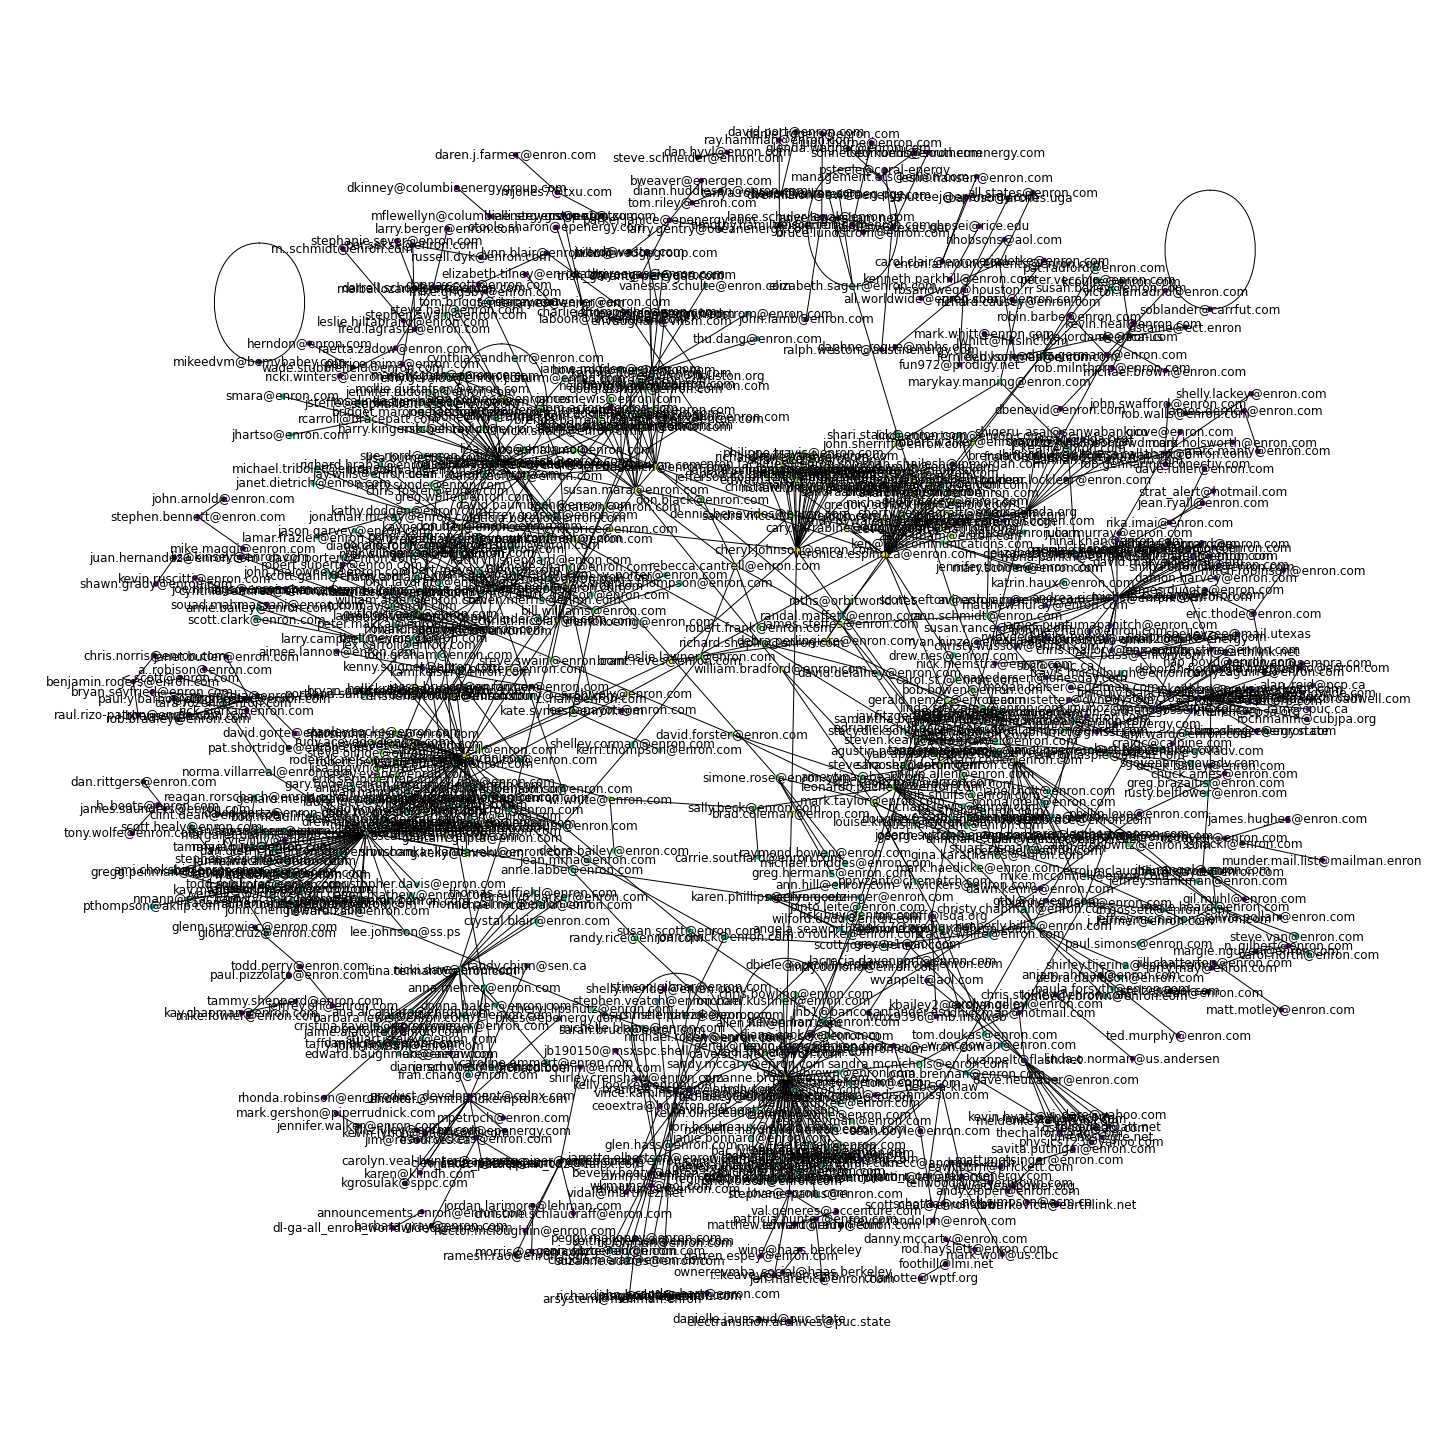

In [ ]:
# next step we can define and draw the social network
import networkx as nx
import matplotlib.pyplot as plt

# we first plot the sender and recipient relationship from the random 200 samples we drawn 
# define the graph
G1 = nx.from_pandas_edgelist(after_split.sample(round(0.1*len(after_split)), random_state = 0), "sender", "receiver")

# we define the closeness measure
closeness_G1 = nx.closeness_centrality(G1)
closeness_G1 = list(closeness_G1.values())

# plot the network
plt.figure(figsize = (20,20))
pos1 = nx.spring_layout(G1, k=.1)
nx.draw(G1, pos1, node_size = 20, node_color = closeness_G1, with_labels = True)
plt.show()

Note: Round circle here is self loop which means the sender and receipient is the same person

In this network plot we can clearly see that there are a few clusters in the network which is what I meant by "close social circle". This means that these people have closer contact with each other and have larger chance of sending and receiving emails from each other.

We see that some of the nodes are unlinked to the rest of the clusters. However, this does not represent the whole picture of this dataset because  we are only taking a random small sample and it is not definite that these "standalone" nodes are indeed far from the clusters. To do a more meaningful visual analysis, we will need to do an extraction of the data containing particular entity names or email addresses. Here we are just demonstarte our idea for a potential algorithm for better sender prediction.

Next we can look at degree centrality, which basically measures the extent to which a given node is connected to all the other nodes.

So we can visualize the connection among these 1000 people

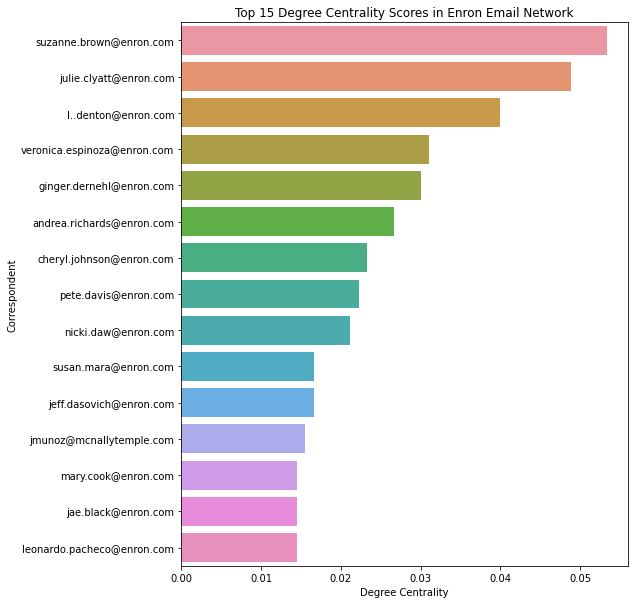

In [ ]:
import seaborn as sns
# here we extract the degree centrality and reorder them from max to min
# Therefore we got people with most connections in the data
cent = nx.degree_centrality(G1)
name = []
centrality = []

for key, value in cent.items():
    name.append(key)
    centrality.append(value)

cent = pd.DataFrame()    
cent['name'] = name
cent['centrality'] = centrality
cent = cent.sort_values(by='centrality', ascending=False)

plt.figure(figsize=(8, 10))
_ = sns.barplot(x='centrality', y='name', data=cent[:15], orient='h')
_ = plt.xlabel('Degree Centrality')
_ = plt.ylabel('Correspondent')
_ = plt.title('Top 15 Degree Centrality Scores in Enron Email Network')
plt.show()

Next, instead of drawing random samples we can specify email address and draw the connection from that person. 
From our centrality analysis, Suzanne seems like have the most of connections, then if we set Suzanne as the center of the graph and explore her network...



In [ ]:
df_x = search("suzanne.brown@enron.com")

In [ ]:
G = nx.from_pandas_edgelist(df_x, 'sender', 'receiver', edge_attr=['subj'])

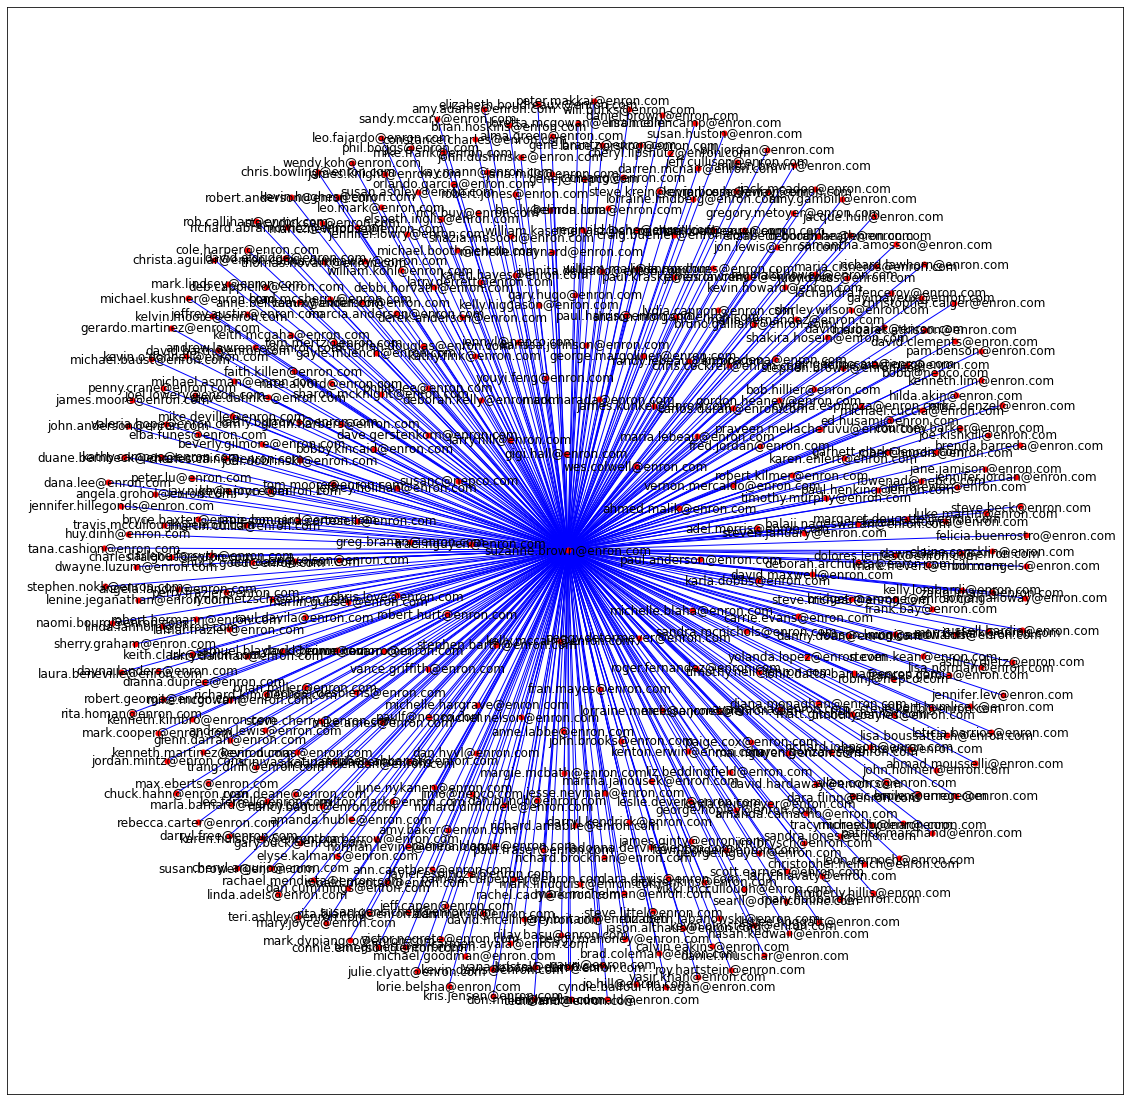

In [ ]:
plt.figure(figsize=(20,20))
pos = nx.spring_layout(G, k=.1)
nx.draw_networkx(G, pos, node_size=25, node_color='red', with_labels=True, edge_color='blue')
plt.show()

We can see her entire network within the sample. By doing the same process on the entire dataset, we can predict the sender from the receipient information based on his/her social network connection

Now after we analyzed the first one on the list, let's check out the last one on the list, leonardo.pacheco@enron.com

In [ ]:
df_y = search("leonardo.pacheco@enron.com")

                          sender                  receiver  \
1316  leonardo.pacheco@enron.com     kenneth.lay@enron.com   
1317  leonardo.pacheco@enron.com   jeff.skilling@enron.com   
1318  leonardo.pacheco@enron.com   joseph.sutton@enron.com   
1319  leonardo.pacheco@enron.com    cliff.baxter@enron.com   
1320  leonardo.pacheco@enron.com  mike.mcconnell@enron.com   
...                          ...                       ...   
7068  leonardo.pacheco@enron.com   philippe.bibi@enron.com   
7069  leonardo.pacheco@enron.com     steven.kean@enron.com   
7070  leonardo.pacheco@enron.com    bruce.garner@enron.com   
7071  leonardo.pacheco@enron.com  mark.pickering@enron.com   
7072  leonardo.pacheco@enron.com    paul.goddard@enron.com   

                                                   subj  
1316  [EnronOnline, Management, Report, for, June, 2...  
1317  [EnronOnline, Management, Report, for, June, 2...  
1318  [EnronOnline, Management, Report, for, June, 2...  
1319  [EnronOnline, Man

In [ ]:
G1 = nx.from_pandas_edgelist(df_y, 'sender', 'receiver', edge_attr=['subj'])

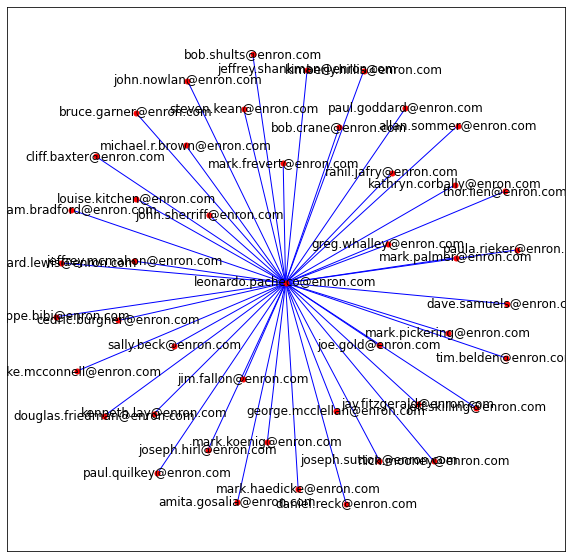

In [ ]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G1, k=.1)
nx.draw_networkx(G1, pos, node_size=25, node_color='red', with_labels=True, edge_color='blue')
plt.show()